## Notebook 1B: Multivariate regression of energy consumption

**1. Prepare Problem**

In [1]:
# a) Load libraries
import pandas as pd
from pandas import set_option
from pandas import DataFrame

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.models import Sequential
from keras.layers import BatchNormalization, Dropout, Dense 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score

from pickle import dump

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# b) Load dataset
# Load and view each file in the dataset
data = pd.read_csv('EPB_data.csv', header=0)
print(data.shape)
print(data.head(10))
print(data.dtypes)

(768, 10)
   Relative Compactness  Surface Area  Wall Area  Roof Area  Overall Height  \
0                  0.98         514.5      294.0     110.25             7.0   
1                  0.98         514.5      294.0     110.25             7.0   
2                  0.98         514.5      294.0     110.25             7.0   
3                  0.98         514.5      294.0     110.25             7.0   
4                  0.90         563.5      318.5     122.50             7.0   
5                  0.90         563.5      318.5     122.50             7.0   
6                  0.90         563.5      318.5     122.50             7.0   
7                  0.90         563.5      318.5     122.50             7.0   
8                  0.86         588.0      294.0     147.00             7.0   
9                  0.86         588.0      294.0     147.00             7.0   

   Orientation  Glazing Area  Glazing Area Distribution  Heating Load  \
0            2           0.0                   

One of the approach in optimizing building energy efficiency is to minimize total energy consumption, which is the sum of heating and cooling.

In [3]:
# Define features and label
X = data.drop(columns=['Heating Load', 'Cooling Load'], axis = 1)
y = data[['Heating Load', 'Cooling Load']]
print(X.shape, y.shape)

(768, 8) (768, 2)


**2. Dataset summary**

In [4]:
# a) Descriptive statistics
set_option("display.precision", 3)
print(data.describe())

       Relative Compactness  Surface Area  Wall Area  Roof Area  \
count               768.000       768.000    768.000    768.000   
mean                  0.764       671.708    318.500    176.604   
std                   0.106        88.086     43.626     45.166   
min                   0.620       514.500    245.000    110.250   
25%                   0.682       606.375    294.000    140.875   
50%                   0.750       673.750    318.500    183.750   
75%                   0.830       741.125    343.000    220.500   
max                   0.980       808.500    416.500    220.500   

       Overall Height  Orientation  Glazing Area  Glazing Area Distribution  \
count         768.000      768.000       768.000                    768.000   
mean            5.250        3.500         0.234                      2.812   
std             1.751        1.119         0.133                      1.551   
min             3.500        2.000         0.000                      0.000   
2

In [5]:
# checking categorical features
cat_features = data.select_dtypes(include='O').keys()
# display variabels
cat_features

Index([], dtype='object')

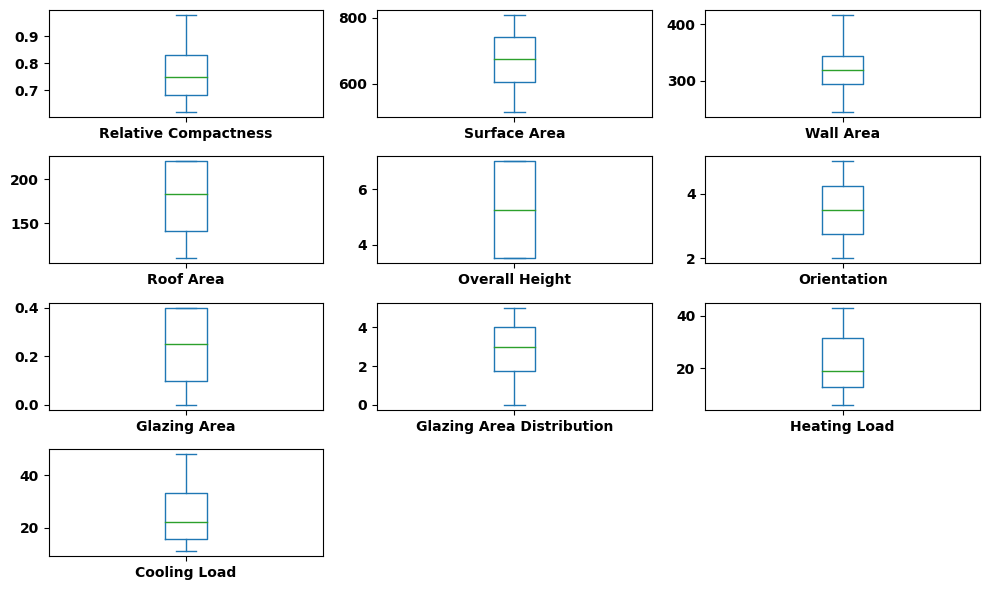

In [6]:
# b) Data visualizations
# Box and Whisker Plots of a few features

plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.autolayout"] = True

raw_plot = pd.DataFrame(data)
raw_plot.plot(kind='box', subplots=True, layout=(4,3), sharex=False, sharey=False)
plt.show()

We can see the data skewed to high values in relative compactness, roof area, glazing area, and cooling load.

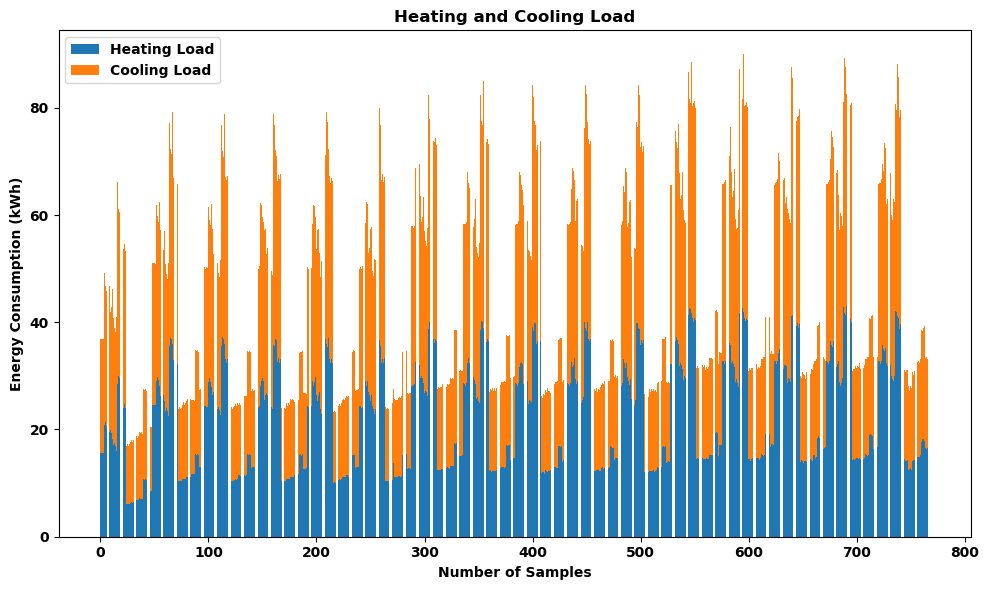

In [7]:
# create the stack bar chart of Heating and Cooling Load
fig, ax = plt.subplots()
ax.bar(np.arange(len(data['Heating Load'])), data['Heating Load'], label='Heating Load')
ax.bar(np.arange(len(data['Cooling Load'])), data['Cooling Load'], bottom=data['Heating Load'], label='Cooling Load')

# add labels, title and legend
ax.set_xlabel('Number of Samples')
ax.set_ylabel('Energy Consumption (kWh)')
ax.set_title('Heating and Cooling Load')
ax.legend()

# show the plot
plt.show()

The data displays a cyclical pattern that may have resulted from the measurements taken on weekdays (with longer hours) and weekends.

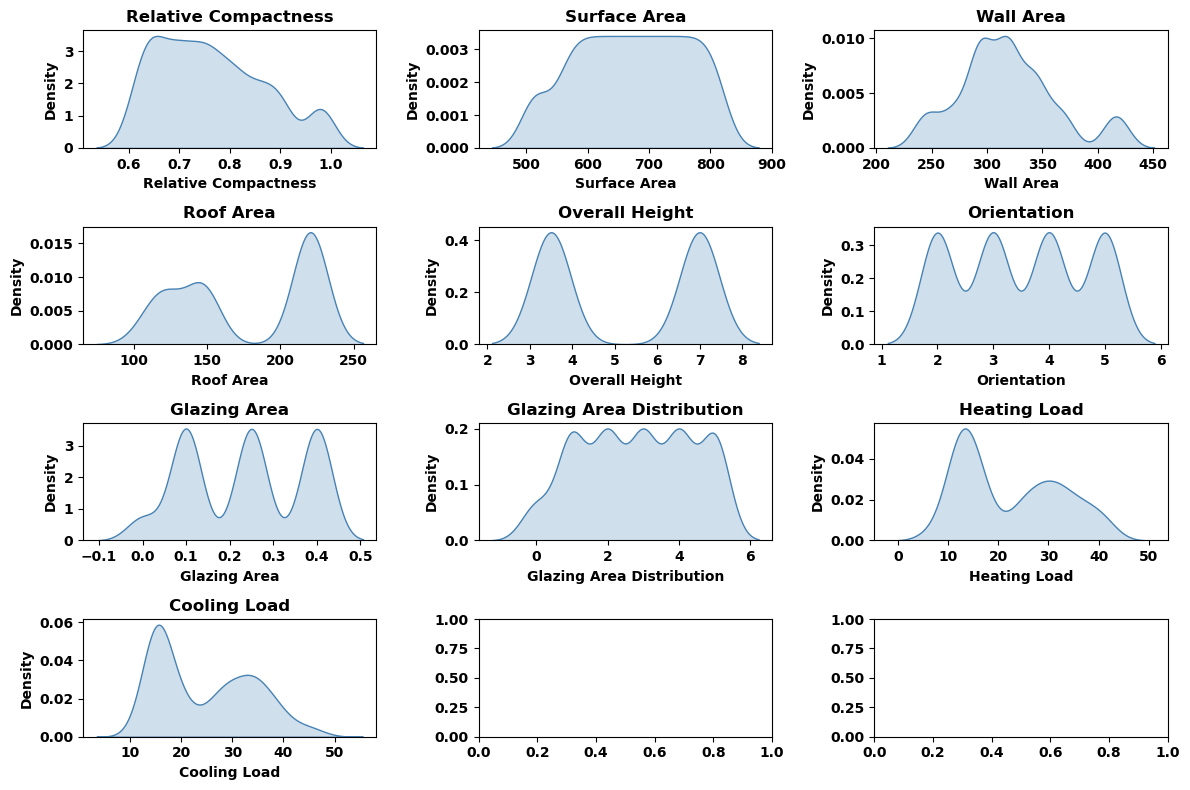

In [8]:
# Create a figure with subplots
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 8))

# Flatten the axes array to simplify plotting
axes = axes.flatten()

# Loop through each feature and create a density plot
for i, feature in enumerate(raw_plot.columns):
    sns.kdeplot(raw_plot[feature], ax=axes[i], color='steelblue', fill=True)
    axes[i].set_title(feature)

# Adjust the layout and spacing of the subplots
fig.tight_layout()

plt.show()

The dataset seems to be complex as most of features exhibit non-Gaussian distributions, except for the Surface Area. There are several factors that could cause non-Gaussian distributions, including outliers, measurement errors, or the inherent characteristics of the building designs.

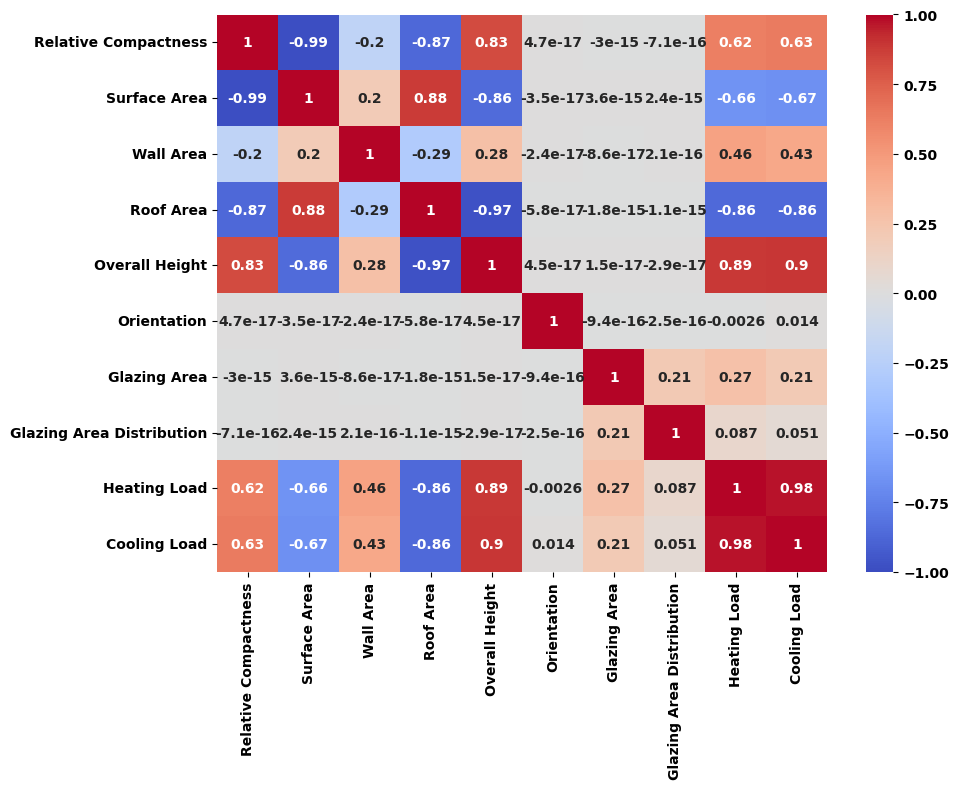

In [9]:
# correlation matrix between all pairs of attributes
corr_matrix = data.corr(method='pearson')

# Create a heatmap using seaborn
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, vmin=-1, vmax=1, annot=True, cmap="coolwarm", ax=ax)

plt.show()

According to the correlation matrix, the heating and cooling loads, as well as energy consumption, exhibit strong correlations with the overall height, orientation, and to some extent, the surface area. The orientation is considered to be an uncertain factor in building design due to limited choices compared to other variables and it plays a significant role in determining the energy efficiency of a building.

**3. Prepare Data**

In [10]:
# a) Data Cleaning
# summarize the number of unique values in each column
print(data.nunique())

Relative Compactness          12
Surface Area                  12
Wall Area                      7
Roof Area                      4
Overall Height                 2
Orientation                    4
Glazing Area                   4
Glazing Area Distribution      6
Heating Load                 586
Cooling Load                 636
dtype: int64


In [11]:
# Identify columns with missing values and count the number of missing values
data.columns[data.isnull().any()]
print(data.isnull().sum())

Relative Compactness         0
Surface Area                 0
Wall Area                    0
Roof Area                    0
Overall Height               0
Orientation                  0
Glazing Area                 0
Glazing Area Distribution    0
Heating Load                 0
Cooling Load                 0
dtype: int64


It is necessary to eliminate outliers in numerical data columns to improve the accuracy of training and validation processes. This can be done by determining the correlation between these columns and the target variable, identifying columns with low correlation, and then filtering out values that fall outside of the lower and upper bounds.

In [12]:
# calculate the correlation between numerical columns and target variables
corr_matrix = data.select_dtypes(include=np.number).corrwith(data['Heating Load']).sort_values(ascending=False)

# filter columns with low correlation 
corr_threshold = 0.05
low_corr_columns = corr_matrix[corr_matrix.abs() < corr_threshold].index

# remove outliers from numerical columns with low correlation
for column in low_corr_columns:
    lower = data[column].quantile(0.01)
    upper = data[column].quantile(0.99)
    data[column] = data[column].clip(lower, upper)

In [13]:
# calculate the correlation between numerical columns and target variables
corr_matrix = data.select_dtypes(include=np.number).corrwith(data['Cooling Load']).sort_values(ascending=False)

# filter columns with low correlation 
corr_threshold = 0.05
low_corr_columns = corr_matrix[corr_matrix.abs() < corr_threshold].index

# remove outliers from numerical columns with low correlation
for column in low_corr_columns:
    lower = data[column].quantile(0.01)
    upper = data[column].quantile(0.99)
    data[column] = data[column].clip(lower, upper)

In [14]:
# b) Split-out dataset into train and validation sets

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=1)

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(576, 8) (576, 2) (192, 8) (192, 2)


In [15]:
# c) Data Transforms
# Standardize the dataset by rescaling the distribution of values 

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)

**4. Evaluate Algorithms**

In [16]:
# a) Spot check algorithms using cross-validation technique
num_folds = 8
seed = 8

# Select 5 most popular linear and tree-based algorithms for evaluation
models = []
models.append(('LR', LinearRegression()))
models.append(('EN', ElasticNet()))
models.append(('RF', RandomForestRegressor()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('SVR', MultiOutputRegressor(SVR(gamma='auto'))))

In [17]:
# Neural Network algorithms
# create keras Sequential model
def baseline_model():
    model = Sequential()
    model.add(Dense(300, input_shape = (8, ), activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(200, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(100, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(2))
    # Compile model
    model.compile(optimizer = 'adam',
                loss = 'mean_squared_error',
                metrics=['mse'])
    return model

# Build model
model_NN = baseline_model()
models.append(('NN', model_NN))

In [18]:
# Define a callback for early stopping if the validation loss does not improve for 10 consecutive 
# epochs (patience=10).
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

In [19]:
results = []
alg_names = []

# Initialize the KerasRegressor estimator with early stopping
estimator = KerasRegressor(model=model_NN, batch_size=128, verbose=1, callbacks=[early_stopping])

for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    
    # modify loop for NN
    if name != 'NN':
        cvs = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
    else:    
        validation_data = (X_val, y_val)
        cvs = cross_val_score(estimator, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error', fit_params={'validation_data': validation_data, 'epochs': 150})
       
    results.append(cvs)
    alg_names.append(name)
    output = "%s: %f (%f)" % (name, cvs.mean(), cvs.std())
    print(output)

LR: -8.863599 (1.261067)
EN: -44.681735 (8.746579)
RF: -1.689117 (0.350230)
KNN: -8.509963 (2.116446)
SVR: -11.050826 (2.213697)
INFO:tensorflow:Assets written to: C:\Users\huyha\AppData\Local\Temp\tmpflal5gje\assets
Epoch 1/150
4/4 [==============================] - 2s 137ms/step - loss: 608.9567 - mse: 608.9567 - val_loss: 693.9111 - val_mse: 693.9111
Epoch 2/150
4/4 [==============================] - 0s 17ms/step - loss: 582.9422 - mse: 582.9422 - val_loss: 687.4919 - val_mse: 687.4919
Epoch 3/150
4/4 [==============================] - 0s 19ms/step - loss: 566.7593 - mse: 566.7593 - val_loss: 679.9434 - val_mse: 679.9434
Epoch 4/150
4/4 [==============================] - 0s 18ms/step - loss: 555.1415 - mse: 555.1415 - val_loss: 670.8430 - val_mse: 670.8430
Epoch 5/150
4/4 [==============================] - 0s 18ms/step - loss: 544.6531 - mse: 544.6531 - val_loss: 660.1086 - val_mse: 660.1086
Epoch 6/150
4/4 [==============================] - 0s 18ms/step - loss: 538.9494 - mse: 538.

4/4 [==============================] - 0s 16ms/step - loss: 239.3645 - mse: 239.3645 - val_loss: 216.5052 - val_mse: 216.5052
Epoch 59/150
4/4 [==============================] - 0s 16ms/step - loss: 234.7460 - mse: 234.7460 - val_loss: 209.9411 - val_mse: 209.9411
Epoch 60/150
4/4 [==============================] - 0s 14ms/step - loss: 217.4332 - mse: 217.4332 - val_loss: 202.4181 - val_mse: 202.4181
Epoch 61/150
4/4 [==============================] - 0s 14ms/step - loss: 211.9277 - mse: 211.9277 - val_loss: 196.4841 - val_mse: 196.4841
Epoch 62/150
4/4 [==============================] - 0s 16ms/step - loss: 208.7944 - mse: 208.7944 - val_loss: 188.7025 - val_mse: 188.7025
Epoch 63/150
4/4 [==============================] - 0s 16ms/step - loss: 200.7994 - mse: 200.7994 - val_loss: 180.3095 - val_mse: 180.3095
Epoch 64/150
4/4 [==============================] - 0s 16ms/step - loss: 192.9283 - mse: 192.9283 - val_loss: 174.1897 - val_mse: 174.1897
Epoch 65/150
4/4 [======================

4/4 [==============================] - 0s 18ms/step - loss: 24.8573 - mse: 24.8573 - val_loss: 12.1252 - val_mse: 12.1252
Epoch 119/150
4/4 [==============================] - 0s 15ms/step - loss: 24.3883 - mse: 24.3883 - val_loss: 11.9743 - val_mse: 11.9743
Epoch 120/150
4/4 [==============================] - 0s 16ms/step - loss: 22.2342 - mse: 22.2342 - val_loss: 11.6232 - val_mse: 11.6232
Epoch 121/150
4/4 [==============================] - 0s 18ms/step - loss: 21.9037 - mse: 21.9037 - val_loss: 11.2353 - val_mse: 11.2353
Epoch 122/150
4/4 [==============================] - 0s 16ms/step - loss: 22.5786 - mse: 22.5786 - val_loss: 10.9788 - val_mse: 10.9788
Epoch 123/150
4/4 [==============================] - 0s 16ms/step - loss: 21.9925 - mse: 21.9925 - val_loss: 10.6251 - val_mse: 10.6251
Epoch 124/150
4/4 [==============================] - 0s 16ms/step - loss: 22.6155 - mse: 22.6155 - val_loss: 9.9478 - val_mse: 9.9478
Epoch 125/150
4/4 [==============================] - 0s 14ms/ste

4/4 [==============================] - 0s 11ms/step - loss: 485.4889 - mse: 485.4889 - val_loss: 444.0487 - val_mse: 444.0487
Epoch 28/150
4/4 [==============================] - 0s 15ms/step - loss: 479.1413 - mse: 479.1413 - val_loss: 438.8091 - val_mse: 438.8091
Epoch 29/150
4/4 [==============================] - 0s 15ms/step - loss: 471.0215 - mse: 471.0215 - val_loss: 433.0878 - val_mse: 433.0878
Epoch 30/150
4/4 [==============================] - 0s 15ms/step - loss: 471.2730 - mse: 471.2730 - val_loss: 426.5768 - val_mse: 426.5768
Epoch 31/150
4/4 [==============================] - 0s 11ms/step - loss: 462.1052 - mse: 462.1052 - val_loss: 420.4696 - val_mse: 420.4696
Epoch 32/150
4/4 [==============================] - 0s 16ms/step - loss: 461.4401 - mse: 461.4401 - val_loss: 414.0383 - val_mse: 414.0383
Epoch 33/150
4/4 [==============================] - 0s 16ms/step - loss: 448.3129 - mse: 448.3129 - val_loss: 407.2052 - val_mse: 407.2052
Epoch 34/150
4/4 [======================

4/4 [==============================] - 0s 17ms/step - loss: 67.6309 - mse: 67.6309 - val_loss: 57.9942 - val_mse: 57.9942
Epoch 87/150
4/4 [==============================] - 0s 16ms/step - loss: 71.1108 - mse: 71.1108 - val_loss: 55.3667 - val_mse: 55.3667
Epoch 88/150
4/4 [==============================] - 0s 15ms/step - loss: 68.4023 - mse: 68.4023 - val_loss: 52.1653 - val_mse: 52.1653
Epoch 89/150
4/4 [==============================] - 0s 15ms/step - loss: 56.6023 - mse: 56.6023 - val_loss: 49.0117 - val_mse: 49.0117
Epoch 90/150
4/4 [==============================] - 0s 17ms/step - loss: 59.5645 - mse: 59.5645 - val_loss: 43.1717 - val_mse: 43.1717
Epoch 91/150
4/4 [==============================] - 0s 15ms/step - loss: 54.0215 - mse: 54.0215 - val_loss: 37.9222 - val_mse: 37.9222
Epoch 92/150
4/4 [==============================] - 0s 17ms/step - loss: 52.8544 - mse: 52.8544 - val_loss: 34.5321 - val_mse: 34.5321
Epoch 93/150
4/4 [==============================] - 0s 16ms/step - l

Epoch 147/150
4/4 [==============================] - 0s 15ms/step - loss: 19.5769 - mse: 19.5769 - val_loss: 7.7262 - val_mse: 7.7262
Epoch 148/150
4/4 [==============================] - 0s 17ms/step - loss: 17.6383 - mse: 17.6383 - val_loss: 7.4977 - val_mse: 7.4977
Epoch 149/150
4/4 [==============================] - 0s 15ms/step - loss: 20.4724 - mse: 20.4724 - val_loss: 7.4908 - val_mse: 7.4908
Epoch 150/150
1/1 [==============================] - 0s 94ms/step
INFO:tensorflow:Assets written to: C:\Users\huyha\AppData\Local\Temp\tmpw9a99b84\assets
Epoch 1/150
4/4 [==============================] - 1s 74ms/step - loss: 609.0414 - mse: 609.0414 - val_loss: 693.4536 - val_mse: 693.4536
Epoch 2/150
4/4 [==============================] - 0s 16ms/step - loss: 584.1165 - mse: 584.1165 - val_loss: 687.5020 - val_mse: 687.5020
Epoch 3/150
4/4 [==============================] - 0s 16ms/step - loss: 573.3819 - mse: 573.3818 - val_loss: 680.4978 - val_mse: 680.4978
Epoch 4/150
4/4 [=============

4/4 [==============================] - 0s 16ms/step - loss: 267.4891 - mse: 267.4891 - val_loss: 236.2043 - val_mse: 236.2043
Epoch 56/150
4/4 [==============================] - 0s 15ms/step - loss: 263.5621 - mse: 263.5621 - val_loss: 228.6017 - val_mse: 228.6017
Epoch 57/150
4/4 [==============================] - 0s 15ms/step - loss: 256.4250 - mse: 256.4250 - val_loss: 220.1445 - val_mse: 220.1445
Epoch 58/150
4/4 [==============================] - 0s 15ms/step - loss: 247.9207 - mse: 247.9207 - val_loss: 209.2008 - val_mse: 209.2008
Epoch 59/150
4/4 [==============================] - 0s 15ms/step - loss: 242.2670 - mse: 242.2670 - val_loss: 201.1747 - val_mse: 201.1747
Epoch 60/150
4/4 [==============================] - 0s 15ms/step - loss: 230.5056 - mse: 230.5056 - val_loss: 194.7149 - val_mse: 194.7149
Epoch 61/150
4/4 [==============================] - 0s 14ms/step - loss: 219.6988 - mse: 219.6988 - val_loss: 188.3090 - val_mse: 188.3090
Epoch 62/150
4/4 [======================

Epoch 115/150
4/4 [==============================] - 0s 16ms/step - loss: 25.3006 - mse: 25.3006 - val_loss: 13.0499 - val_mse: 13.0499
Epoch 116/150
4/4 [==============================] - 0s 17ms/step - loss: 23.8541 - mse: 23.8541 - val_loss: 12.4706 - val_mse: 12.4706
Epoch 117/150
4/4 [==============================] - 0s 16ms/step - loss: 21.1921 - mse: 21.1921 - val_loss: 12.1856 - val_mse: 12.1856
Epoch 118/150
4/4 [==============================] - 0s 17ms/step - loss: 24.0970 - mse: 24.0970 - val_loss: 11.5485 - val_mse: 11.5485
Epoch 119/150
4/4 [==============================] - 0s 15ms/step - loss: 22.9742 - mse: 22.9742 - val_loss: 11.3158 - val_mse: 11.3158
Epoch 120/150
4/4 [==============================] - 0s 17ms/step - loss: 25.2528 - mse: 25.2528 - val_loss: 10.7113 - val_mse: 10.7113
Epoch 121/150
4/4 [==============================] - 0s 16ms/step - loss: 25.9778 - mse: 25.9778 - val_loss: 10.3325 - val_mse: 10.3325
Epoch 122/150
4/4 [=============================

4/4 [==============================] - 0s 16ms/step - loss: 488.3729 - mse: 488.3729 - val_loss: 478.8286 - val_mse: 478.8286
Epoch 25/150
4/4 [==============================] - 0s 16ms/step - loss: 482.8683 - mse: 482.8683 - val_loss: 473.4290 - val_mse: 473.4290
Epoch 26/150
4/4 [==============================] - 0s 15ms/step - loss: 478.0202 - mse: 478.0202 - val_loss: 467.7828 - val_mse: 467.7828
Epoch 27/150
4/4 [==============================] - 0s 18ms/step - loss: 471.0885 - mse: 471.0885 - val_loss: 461.6943 - val_mse: 461.6943
Epoch 28/150
4/4 [==============================] - 0s 16ms/step - loss: 472.8013 - mse: 472.8013 - val_loss: 453.5567 - val_mse: 453.5567
Epoch 29/150
4/4 [==============================] - 0s 16ms/step - loss: 464.7184 - mse: 464.7184 - val_loss: 445.6406 - val_mse: 445.6406
Epoch 30/150
4/4 [==============================] - 0s 17ms/step - loss: 458.8749 - mse: 458.8749 - val_loss: 438.3525 - val_mse: 438.3525
Epoch 31/150
4/4 [======================

4/4 [==============================] - 0s 15ms/step - loss: 82.3004 - mse: 82.3004 - val_loss: 70.8974 - val_mse: 70.8974
Epoch 84/150
4/4 [==============================] - 0s 15ms/step - loss: 78.2432 - mse: 78.2432 - val_loss: 65.5524 - val_mse: 65.5524
Epoch 85/150
4/4 [==============================] - 0s 15ms/step - loss: 77.8558 - mse: 77.8558 - val_loss: 61.8813 - val_mse: 61.8813
Epoch 86/150
4/4 [==============================] - 0s 15ms/step - loss: 68.8806 - mse: 68.8806 - val_loss: 58.9308 - val_mse: 58.9308
Epoch 87/150
4/4 [==============================] - 0s 15ms/step - loss: 64.1239 - mse: 64.1239 - val_loss: 55.4101 - val_mse: 55.4101
Epoch 88/150
4/4 [==============================] - 0s 16ms/step - loss: 65.4189 - mse: 65.4189 - val_loss: 52.4642 - val_mse: 52.4642
Epoch 89/150
4/4 [==============================] - 0s 16ms/step - loss: 58.1098 - mse: 58.1098 - val_loss: 49.3505 - val_mse: 49.3505
Epoch 90/150
4/4 [==============================] - 0s 16ms/step - l

Epoch 144/150
4/4 [==============================] - 0s 15ms/step - loss: 22.6593 - mse: 22.6593 - val_loss: 7.7364 - val_mse: 7.7364
Epoch 145/150
4/4 [==============================] - 0s 14ms/step - loss: 20.0100 - mse: 20.0100 - val_loss: 7.5865 - val_mse: 7.5865
Epoch 146/150
4/4 [==============================] - 0s 16ms/step - loss: 20.1690 - mse: 20.1690 - val_loss: 7.4655 - val_mse: 7.4655
Epoch 147/150
4/4 [==============================] - 0s 18ms/step - loss: 19.8490 - mse: 19.8490 - val_loss: 7.3863 - val_mse: 7.3863
Epoch 148/150
4/4 [==============================] - 0s 15ms/step - loss: 19.8611 - mse: 19.8611 - val_loss: 7.2702 - val_mse: 7.2702
Epoch 149/150
4/4 [==============================] - 0s 16ms/step - loss: 21.2881 - mse: 21.2881 - val_loss: 7.0812 - val_mse: 7.0812
Epoch 150/150
1/1 [==============================] - 0s 87ms/step
INFO:tensorflow:Assets written to: C:\Users\huyha\AppData\Local\Temp\tmpw9s7pdp4\assets
Epoch 1/150
4/4 [=========================

4/4 [==============================] - 0s 15ms/step - loss: 311.5542 - mse: 311.5542 - val_loss: 278.0880 - val_mse: 278.0880
Epoch 53/150
4/4 [==============================] - 0s 16ms/step - loss: 301.9315 - mse: 301.9315 - val_loss: 266.5375 - val_mse: 266.5375
Epoch 54/150
4/4 [==============================] - 0s 16ms/step - loss: 295.4984 - mse: 295.4984 - val_loss: 257.4763 - val_mse: 257.4763
Epoch 55/150
4/4 [==============================] - 0s 18ms/step - loss: 283.1688 - mse: 283.1688 - val_loss: 250.7417 - val_mse: 250.7417
Epoch 56/150
4/4 [==============================] - 0s 16ms/step - loss: 274.8406 - mse: 274.8406 - val_loss: 244.0003 - val_mse: 244.0003
Epoch 57/150
4/4 [==============================] - 0s 15ms/step - loss: 270.8441 - mse: 270.8441 - val_loss: 237.6367 - val_mse: 237.6367
Epoch 58/150
4/4 [==============================] - 0s 16ms/step - loss: 255.9369 - mse: 255.9369 - val_loss: 229.4095 - val_mse: 229.4095
Epoch 59/150
4/4 [======================

Epoch 112/150
4/4 [==============================] - 0s 16ms/step - loss: 27.3613 - mse: 27.3613 - val_loss: 15.6393 - val_mse: 15.6393
Epoch 113/150
4/4 [==============================] - 0s 15ms/step - loss: 25.3826 - mse: 25.3826 - val_loss: 14.8198 - val_mse: 14.8198
Epoch 114/150
4/4 [==============================] - 0s 17ms/step - loss: 27.7678 - mse: 27.7678 - val_loss: 14.2418 - val_mse: 14.2418
Epoch 115/150
4/4 [==============================] - 0s 16ms/step - loss: 26.7883 - mse: 26.7883 - val_loss: 13.9225 - val_mse: 13.9225
Epoch 116/150
4/4 [==============================] - 0s 16ms/step - loss: 25.4874 - mse: 25.4874 - val_loss: 13.0506 - val_mse: 13.0506
Epoch 117/150
4/4 [==============================] - 0s 15ms/step - loss: 24.5612 - mse: 24.5612 - val_loss: 11.5424 - val_mse: 11.5424
Epoch 118/150
4/4 [==============================] - 0s 15ms/step - loss: 24.5258 - mse: 24.5258 - val_loss: 10.9773 - val_mse: 10.9773
Epoch 119/150
4/4 [=============================

4/4 [==============================] - 0s 16ms/step - loss: 506.2300 - mse: 506.2300 - val_loss: 535.1704 - val_mse: 535.1704
Epoch 17/150
4/4 [==============================] - 0s 18ms/step - loss: 502.1083 - mse: 502.1083 - val_loss: 527.6756 - val_mse: 527.6756
Epoch 18/150
4/4 [==============================] - 0s 17ms/step - loss: 501.3824 - mse: 501.3824 - val_loss: 519.9120 - val_mse: 519.9120
Epoch 19/150
4/4 [==============================] - 0s 16ms/step - loss: 500.0100 - mse: 500.0100 - val_loss: 512.0648 - val_mse: 512.0648
Epoch 20/150
4/4 [==============================] - 0s 16ms/step - loss: 490.4763 - mse: 490.4763 - val_loss: 503.5864 - val_mse: 503.5864
Epoch 21/150
4/4 [==============================] - 0s 16ms/step - loss: 487.4706 - mse: 487.4706 - val_loss: 494.5955 - val_mse: 494.5955
Epoch 22/150
4/4 [==============================] - 0s 16ms/step - loss: 486.6743 - mse: 486.6743 - val_loss: 485.3023 - val_mse: 485.3023
Epoch 23/150
4/4 [======================

4/4 [==============================] - 0s 16ms/step - loss: 114.9029 - mse: 114.9029 - val_loss: 108.4093 - val_mse: 108.4093
Epoch 76/150
4/4 [==============================] - 0s 18ms/step - loss: 118.0319 - mse: 118.0319 - val_loss: 101.2495 - val_mse: 101.2495
Epoch 77/150
4/4 [==============================] - 0s 18ms/step - loss: 111.2626 - mse: 111.2626 - val_loss: 92.5550 - val_mse: 92.5550
Epoch 78/150
4/4 [==============================] - 0s 17ms/step - loss: 104.3356 - mse: 104.3356 - val_loss: 85.9925 - val_mse: 85.9925
Epoch 79/150
4/4 [==============================] - 0s 16ms/step - loss: 97.7674 - mse: 97.7674 - val_loss: 82.6441 - val_mse: 82.6441
Epoch 80/150
4/4 [==============================] - 0s 16ms/step - loss: 91.2478 - mse: 91.2478 - val_loss: 79.5565 - val_mse: 79.5565
Epoch 81/150
4/4 [==============================] - 0s 15ms/step - loss: 84.8569 - mse: 84.8569 - val_loss: 75.6034 - val_mse: 75.6034
Epoch 82/150
4/4 [==============================] - 0s 1

4/4 [==============================] - 0s 15ms/step - loss: 19.9726 - mse: 19.9726 - val_loss: 8.5989 - val_mse: 8.5989
Epoch 136/150
4/4 [==============================] - 0s 15ms/step - loss: 20.3223 - mse: 20.3223 - val_loss: 8.3930 - val_mse: 8.3930
Epoch 137/150
4/4 [==============================] - 0s 16ms/step - loss: 22.5532 - mse: 22.5532 - val_loss: 8.3362 - val_mse: 8.3362
Epoch 138/150
4/4 [==============================] - 0s 16ms/step - loss: 18.9502 - mse: 18.9502 - val_loss: 8.2071 - val_mse: 8.2071
Epoch 139/150
4/4 [==============================] - 0s 16ms/step - loss: 22.6812 - mse: 22.6812 - val_loss: 8.1499 - val_mse: 8.1499
Epoch 140/150
4/4 [==============================] - 0s 16ms/step - loss: 22.2406 - mse: 22.2406 - val_loss: 8.6411 - val_mse: 8.6411
Epoch 141/150
4/4 [==============================] - 0s 15ms/step - loss: 22.6715 - mse: 22.6715 - val_loss: 8.3434 - val_mse: 8.3434
Epoch 142/150
4/4 [==============================] - 0s 16ms/step - loss: 23

4/4 [==============================] - 0s 17ms/step - loss: 413.5227 - mse: 413.5227 - val_loss: 373.8431 - val_mse: 373.8431
Epoch 39/150
4/4 [==============================] - 0s 16ms/step - loss: 408.8766 - mse: 408.8766 - val_loss: 365.9422 - val_mse: 365.9422
Epoch 40/150
4/4 [==============================] - 0s 16ms/step - loss: 404.0817 - mse: 404.0817 - val_loss: 358.1078 - val_mse: 358.1078
Epoch 41/150
4/4 [==============================] - 0s 15ms/step - loss: 397.0017 - mse: 397.0017 - val_loss: 349.1403 - val_mse: 349.1403
Epoch 42/150
4/4 [==============================] - 0s 15ms/step - loss: 388.3865 - mse: 388.3865 - val_loss: 339.8197 - val_mse: 339.8197
Epoch 43/150
4/4 [==============================] - 0s 16ms/step - loss: 382.0338 - mse: 382.0338 - val_loss: 330.3588 - val_mse: 330.3588
Epoch 44/150
4/4 [==============================] - 0s 17ms/step - loss: 380.6445 - mse: 380.6445 - val_loss: 322.2517 - val_mse: 322.2517
Epoch 45/150
4/4 [======================

4/4 [==============================] - 0s 17ms/step - loss: 39.8582 - mse: 39.8582 - val_loss: 26.1715 - val_mse: 26.1715
Epoch 98/150
4/4 [==============================] - 0s 17ms/step - loss: 36.2345 - mse: 36.2345 - val_loss: 25.9903 - val_mse: 25.9903
Epoch 99/150
4/4 [==============================] - 0s 18ms/step - loss: 40.5623 - mse: 40.5623 - val_loss: 25.7921 - val_mse: 25.7921
Epoch 100/150
4/4 [==============================] - 0s 16ms/step - loss: 32.8941 - mse: 32.8941 - val_loss: 24.6617 - val_mse: 24.6617
Epoch 101/150
4/4 [==============================] - 0s 16ms/step - loss: 33.6976 - mse: 33.6976 - val_loss: 22.7857 - val_mse: 22.7857
Epoch 102/150
4/4 [==============================] - 0s 18ms/step - loss: 31.6710 - mse: 31.6710 - val_loss: 21.2453 - val_mse: 21.2453
Epoch 103/150
4/4 [==============================] - 0s 16ms/step - loss: 31.3126 - mse: 31.3126 - val_loss: 20.0128 - val_mse: 20.0128
Epoch 104/150
4/4 [==============================] - 0s 16ms/ste

4/4 [==============================] - 0s 17ms/step - loss: 544.1378 - mse: 544.1378 - val_loss: 649.8476 - val_mse: 649.8476
Epoch 7/150
4/4 [==============================] - 0s 17ms/step - loss: 541.3997 - mse: 541.3997 - val_loss: 637.6099 - val_mse: 637.6099
Epoch 8/150
4/4 [==============================] - 0s 17ms/step - loss: 533.5760 - mse: 533.5760 - val_loss: 624.7576 - val_mse: 624.7576
Epoch 9/150
4/4 [==============================] - 0s 16ms/step - loss: 527.6010 - mse: 527.6010 - val_loss: 611.7079 - val_mse: 611.7079
Epoch 10/150
4/4 [==============================] - 0s 16ms/step - loss: 521.3387 - mse: 521.3387 - val_loss: 598.7936 - val_mse: 598.7936
Epoch 11/150
4/4 [==============================] - 0s 15ms/step - loss: 518.2401 - mse: 518.2401 - val_loss: 586.6064 - val_mse: 586.6064
Epoch 12/150
4/4 [==============================] - 0s 16ms/step - loss: 517.0480 - mse: 517.0480 - val_loss: 574.5790 - val_mse: 574.5790
Epoch 13/150
4/4 [=========================

4/4 [==============================] - 0s 17ms/step - loss: 187.5902 - mse: 187.5902 - val_loss: 181.1713 - val_mse: 181.1713
Epoch 66/150
4/4 [==============================] - 0s 17ms/step - loss: 181.0854 - mse: 181.0854 - val_loss: 172.2617 - val_mse: 172.2617
Epoch 67/150
4/4 [==============================] - 0s 17ms/step - loss: 172.3915 - mse: 172.3915 - val_loss: 163.3068 - val_mse: 163.3068
Epoch 68/150
4/4 [==============================] - 0s 16ms/step - loss: 169.0932 - mse: 169.0932 - val_loss: 154.9286 - val_mse: 154.9286
Epoch 69/150
4/4 [==============================] - 0s 16ms/step - loss: 156.2485 - mse: 156.2485 - val_loss: 147.9371 - val_mse: 147.9371
Epoch 70/150
4/4 [==============================] - 0s 16ms/step - loss: 156.5065 - mse: 156.5065 - val_loss: 141.8506 - val_mse: 141.8506
Epoch 71/150
4/4 [==============================] - 0s 16ms/step - loss: 141.1177 - mse: 141.1177 - val_loss: 135.7118 - val_mse: 135.7118
Epoch 72/150
4/4 [======================

4/4 [==============================] - 0s 17ms/step - loss: 24.4045 - mse: 24.4045 - val_loss: 9.7884 - val_mse: 9.7884
Epoch 126/150
4/4 [==============================] - 0s 17ms/step - loss: 22.9142 - mse: 22.9142 - val_loss: 9.4782 - val_mse: 9.4782
Epoch 127/150
4/4 [==============================] - 0s 17ms/step - loss: 21.9883 - mse: 21.9883 - val_loss: 9.2361 - val_mse: 9.2361
Epoch 128/150
4/4 [==============================] - 0s 17ms/step - loss: 22.2005 - mse: 22.2005 - val_loss: 9.0698 - val_mse: 9.0698
Epoch 129/150
4/4 [==============================] - 0s 16ms/step - loss: 22.1466 - mse: 22.1466 - val_loss: 8.8922 - val_mse: 8.8922
Epoch 130/150
4/4 [==============================] - 0s 17ms/step - loss: 19.3053 - mse: 19.3053 - val_loss: 8.9758 - val_mse: 8.9758
Epoch 131/150
4/4 [==============================] - 0s 16ms/step - loss: 21.1683 - mse: 21.1683 - val_loss: 9.2687 - val_mse: 9.2687
Epoch 132/150
4/4 [==============================] - 0s 16ms/step - loss: 21

Epoch 1/500
5/5 [==============================] - 1s 59ms/step - loss: 616.5791 - mse: 616.5791 - val_loss: 692.3652 - val_mse: 692.3652
Epoch 2/500
5/5 [==============================] - 0s 14ms/step - loss: 584.9875 - mse: 584.9875 - val_loss: 684.1837 - val_mse: 684.1837
Epoch 3/500
5/5 [==============================] - 0s 14ms/step - loss: 567.0388 - mse: 567.0388 - val_loss: 673.6699 - val_mse: 673.6699
Epoch 4/500
5/5 [==============================] - 0s 14ms/step - loss: 561.6024 - mse: 561.6024 - val_loss: 661.1407 - val_mse: 661.1407
Epoch 5/500
5/5 [==============================] - 0s 14ms/step - loss: 548.2922 - mse: 548.2922 - val_loss: 646.8663 - val_mse: 646.8663
Epoch 6/500
5/5 [==============================] - 0s 13ms/step - loss: 542.7639 - mse: 542.7639 - val_loss: 631.2789 - val_mse: 631.2789
Epoch 7/500
5/5 [==============================] - 0s 14ms/step - loss: 535.9216 - mse: 535.9216 - val_loss: 615.9169 - val_mse: 615.9169
Epoch 8/500
5/5 [=================

5/5 [==============================] - 0s 12ms/step - loss: 133.1166 - mse: 133.1166 - val_loss: 105.7296 - val_mse: 105.7296
Epoch 61/500
5/5 [==============================] - 0s 11ms/step - loss: 118.6626 - mse: 118.6626 - val_loss: 98.0777 - val_mse: 98.0777
Epoch 62/500
5/5 [==============================] - 0s 12ms/step - loss: 116.2463 - mse: 116.2463 - val_loss: 91.6925 - val_mse: 91.6925
Epoch 63/500
5/5 [==============================] - 0s 11ms/step - loss: 107.3364 - mse: 107.3364 - val_loss: 86.6353 - val_mse: 86.6353
Epoch 64/500
5/5 [==============================] - 0s 11ms/step - loss: 96.7294 - mse: 96.7294 - val_loss: 78.5311 - val_mse: 78.5311
Epoch 65/500
5/5 [==============================] - 0s 12ms/step - loss: 96.7533 - mse: 96.7533 - val_loss: 70.4140 - val_mse: 70.4140
Epoch 66/500
5/5 [==============================] - 0s 13ms/step - loss: 87.2679 - mse: 87.2679 - val_loss: 64.5259 - val_mse: 64.5259
Epoch 67/500
5/5 [==============================] - 0s 12m

Epoch 121/500
5/5 [==============================] - 0s 13ms/step - loss: 19.9059 - mse: 19.9059 - val_loss: 6.9000 - val_mse: 6.9000
Epoch 122/500
5/5 [==============================] - 0s 12ms/step - loss: 22.0765 - mse: 22.0765 - val_loss: 6.7949 - val_mse: 6.7949
Epoch 123/500
5/5 [==============================] - 0s 12ms/step - loss: 19.6036 - mse: 19.6036 - val_loss: 6.8704 - val_mse: 6.8704
Epoch 124/500
5/5 [==============================] - 0s 16ms/step - loss: 21.1786 - mse: 21.1786 - val_loss: 6.8985 - val_mse: 6.8985
Epoch 125/500
5/5 [==============================] - 0s 12ms/step - loss: 22.4972 - mse: 22.4972 - val_loss: 6.7335 - val_mse: 6.7335
Epoch 126/500
5/5 [==============================] - 0s 13ms/step - loss: 18.8568 - mse: 18.8568 - val_loss: 6.4185 - val_mse: 6.4185
Epoch 127/500
5/5 [==============================] - 0s 12ms/step - loss: 20.3705 - mse: 20.3705 - val_loss: 6.4943 - val_mse: 6.4943
Epoch 128/500
5/5 [==============================] - 0s 12ms/s

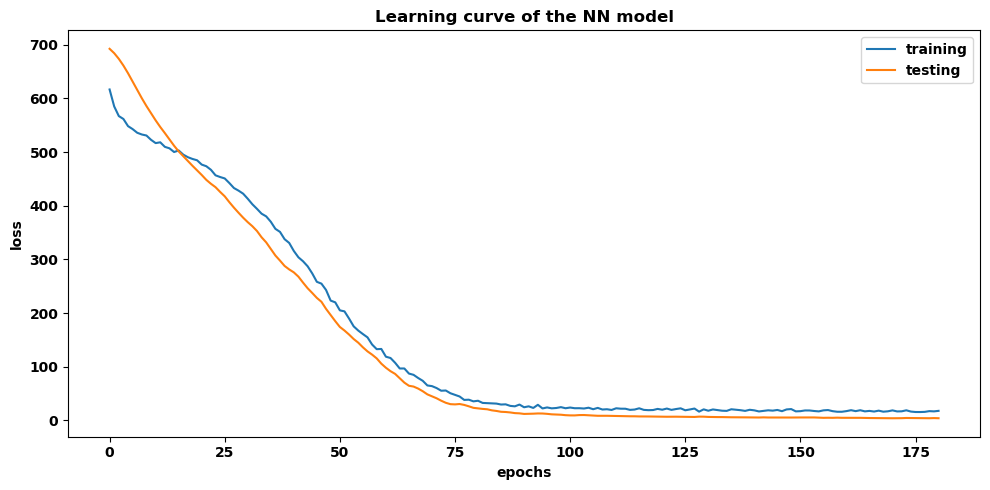

In [20]:
# Plot learning curve of NN model
history = model_NN.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500, batch_size=128, callbacks=[early_stopping])

plt.figure(figsize = (10, 5))
plt.plot(history.history['loss'], label = 'training')
plt.plot(history.history['val_loss'], label = 'testing')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Learning curve of the NN model')
plt.legend()

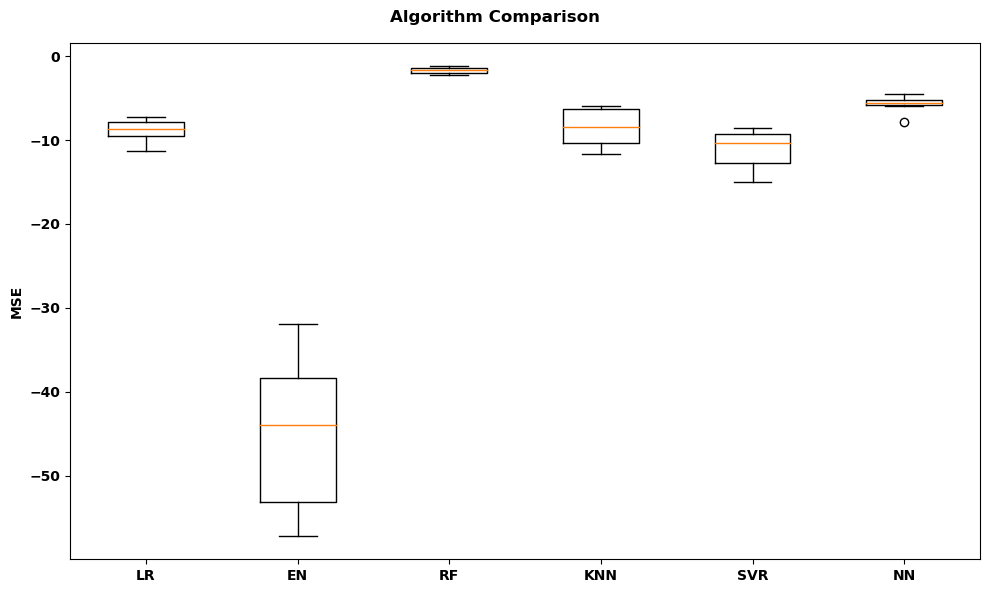

In [21]:
# b) Compare algorithms and the NN model
# Distribution of accuracy values calculated across 8 cross-validation folds.
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot()
plt.boxplot(results)
ax.set_xticklabels(alg_names)
plt.ylabel("MSE")
plt.show()

The Random Forest algorithm demonstrated superior performance compared to the other five machine learning algorithms and the neural network model.

In a regression problem, it is common to use the mean error as a measure of validation. This is done by first calculating the mean absolute error (MAE) of the test data with the mean of dataset, and then calculating the MAE of the test data with the predicted data. 

In [22]:
# Evaluate performance of Random Forest algorithm on validation data
model_RF = RandomForestRegressor()
model_RF.fit(X_train, y_train)
y_pred_RF = model_RF.predict(X_val)
mae_pred_RF = mean_absolute_error(y_val, y_pred_RF)
print("Mean Absolute Error of predicted data: ", mae_pred_RF)

Mean Absolute Error of predicted data:  0.8418854166666667


In [23]:
# Evaluate performance of NN algorithm on validation data
model_NN.fit(X_train, y_train)
y_pred_NN = model_NN.predict(X_val)
print(y_pred_NN.shape)
mae_pred_NN = mean_absolute_error(y_val, y_pred_NN)
print("Mean Absolute Error of predicted data: ", mae_pred_NN)

6/6 [==============================] - 0s 2ms/step
(192, 2)
Mean Absolute Error of predicted data:  1.5929388094941777


In [24]:
# Define baseline mean_absolute_error of y_val in the data set
y_mean = np.mean(y)
y_mean = np.array([y_mean]*len(y_val))
mae_ori = mean_absolute_error(y_val, y_mean)
print("Mean Absolute Error of original data: ", mae_ori)

Mean Absolute Error of original data:  8.900351223415804


D:\Software\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


The resulting MAE values show that Random Forest looks better than neural network model in prediction performance. For the sake of simplicity, I selected Random Forest as the surrogate model for the multi-objective optimization process.

**5. Finalize Model**

In [25]:
# a) Get best model parameters
model_params = model_RF.get_params()

# Print the model's parameters
print(model_params)

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


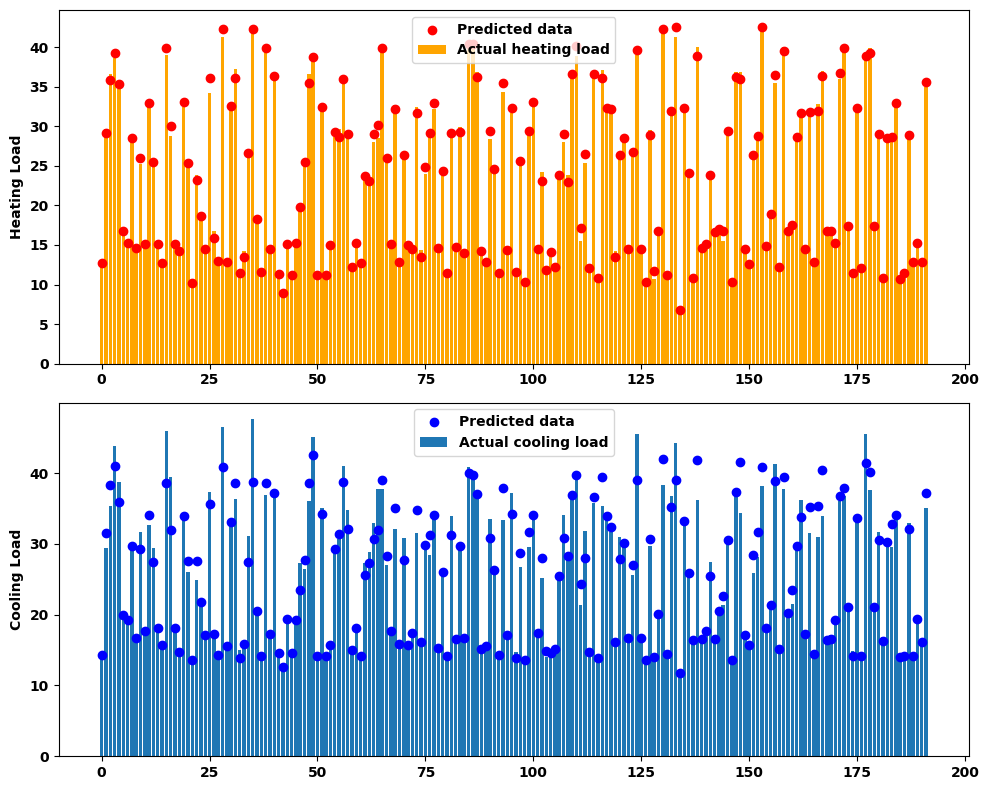

In [26]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot the actual and predicted heating load
ax1.bar(np.arange(len(y_val)), y_val.iloc[:, 0], label='Actual heating load', color='orange')
ax1.scatter(np.arange(len(y_pred_RF)), y_pred_RF[:, 0], label='Predicted data', color='red')
ax1.set_ylabel('Heating Load')
ax1.legend()

# Plot the actual and predicted cooling load
ax2.bar(np.arange(len(y_val)), y_val.iloc[:, 1], label='Actual cooling load')
ax2.scatter(np.arange(len(y_pred_RF)), y_pred_RF[:, 1], label='Predicted data', color='blue')
ax2.set_ylabel('Cooling Load')
ax2.legend()

# Show the plot
plt.show()

In [27]:
# b) Save model for later use
# save the model to disk
filename = 'finalized_model_multivariate.sav'
dump(model_RF, open(filename, 'wb'))

**6. Conclusions**

- Exploratory data analysis indicates that most input variables exhibit non-Gaussian distribution.

- Based on our evaluation of five machine learning algorithms and a neural network model, we selected Random Forest as the surrogate model for multi-objective optimization due to its high score in cross validation and low Mean Squared Error values.

- The Mean Absolute Error values suggest that the prediction accuracy is generally good, although the ElasticNet algorithm may require further refinement.

- The results indicate that the performance of the Keras Sequential neural network model is comparable to that of other machine learning algorithms, and further hyperparameter tuning may improve its predictive accuracy.